# Day 20 Pre-class Assignment: ZOMBIES!!

### <p style="text-align: right;"> &#9989; Burke</p>

____
<img src="https://s-media-cache-ak0.pinimg.com/736x/68/d3/bc/68d3bccc93b1c64bd46c80e95bd400ee.jpg" width=300px>

### Goals for today's pre-class assignment:
* Continue to explore compartmental models using `solve_ivp`
* Understand the dynamics of a disease outbreak models and the parameters that determine their behavior.

### Assignment instructions

**This assignment is due by 11:59 p.m. the day before class,** and should be uploaded into appropriate "Pre-class assignments" submission folder.  Submission instructions can be found at the end of the notebook.

---
In this notebook, we model a zombie invasion and use it to demonstrate how to use SciPy's `solve_ivp`. The model used here is described in the paper by Munz et al.:

[Munz, Hudea, Imad, Smith, "When zombies attack!: mathematical modelling of an outbreak of zombie infection." In J.M. Tchuenche and C. Chiyaka, editors, Infectious Disease Modelling Research Progress, 133-150, 2009.](http://loe.org/images/content/091023/Zombie%20Publication.pdf)

<br>

For those interested, the original [code from the paper is here](https://scipy-cookbook.readthedocs.io/items/Zombie_Apocalypse_ODEINT.html), which has been modified below to improve readability. In this assignment you will be starting with basic, working code and modifying it to model more interesting scenarios. First, read through the following description of the problem and model.

The zombie model is a [**compartmental model**](https://en.wikipedia.org/wiki/Multi-compartment_model) that uses three compartments **S**, **Z**, and **R**.  This is discussed on the chalk board here and in more detail with slightly different, clearer, variables below.  

<img src="https://i.imgur.com/9HTp47I.png" width=800>

As discussed in the Munz et al paper, the compartments represent three groups:
- Susceptible (S)
- Zombie (Z)
- Removed (R)

In short, the _Susceptibles_ are healthy humans that can increase in number with more births and decrease through natural deaths.  Furthermore, _Susceptibles_ can become _Zombies_ via a failed encounter to defend oneself from a zombie.   The _Zombies_ can come from two sources: the resurrected from the deceased (_Removed_ group) and from _Susceptibles_ who have ‘lost’ an encounter with a zombie.  _Zombies_ reduce upon being defeated.  The _Removed_ group represent dead humans and zombies.  This post-apocalyptic world can be represented graphically as a compartmental model:  

### SZR MODEL

<img src="https://i.ibb.co/QDNpn1v/zombie-model.png" alt="zombie-model">

The ODE version of this, using the notation in the immediate model above and in the code below, is:

$$\frac{dS}{dt} = b - aSZ - dS,$$

$$\frac{dZ}{dt} = aSZ + gR - kSZ,$$

$$\frac{dR}{dt} = dS + kSZ - gR.$$

**Note**: The code below doesn't use the same parameter names that are stated in the paper and so you shouldn't be trying to compare the plots in the paper to the ones that you get. In fact, it turns out that the author of the paper was a bit sloppy with their code and wasn't consistent with the parameters used in their model. Additionally, they didn't use an accurate solver like `solve_ivp` to evolve their system! If you take a look at their code at the end of the paper, you can even see that they made a simplifying assumption in their model that isn't well explained in the paper. This is a good example of how **_not_** to write a high-quality paper. Of course, exploring this model is still valuable and we'll make sure we do it correctly!

The code below defines two functions; one called `derivative_szr` and one called `run_simulation`. The first function calculates the derivatives of the compartments $S,Z,R$ and it is the update function that will be passed to `solve_ivp`. The second function is used to solve the ODEs and put the solutions into a plot. 

**Review the code and make sure you understand how it works. Read the comments and the docstring (red code) first to get an understanding of what the code accomplishes**

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
from scipy.integrate import solve_ivp

In [38]:
# Basic Zombie Apocalypse Model Simulation
# ========================================
# This script simulates the dynamics of a zombie apocalypse using a basic SZR (Susceptible-Zombie-Removed) model
# under various initial conditions and parameters. The model accounts for human population dynamics in the presence
# of a zombie outbreak, including natural death, transmission of zombification, resurrection, and the destruction
# of zombies. The goal is to illustrate the impact of these factors on the populations over time.

# Import necessary libraries
# --------------------------
# NumPy for numerical computations
import numpy as np
# Matplotlib for plotting
import matplotlib.pyplot as plt
# SciPy's solve_ivp for solving ordinary differential equations (ODEs)
from scipy.integrate import solve_ivp

# Enhance the display of plots in Jupyter notebooks
%matplotlib inline

# Derivatives function for the SZR model
# ---------------------------------------
# This function calculates the rate of change of the susceptible (S), zombie (Z), and removed (R) populations
# at any given time t, using the current populations and model parameters.
def derivatives_szr(t, y, b, d, a, g, k):
    """
    Compute the derivatives for the SZR model at time t.

    Parameters:
    - t (float): The current time.
    - y (list): A list containing the current values of the variables [S, Z, R].
    - b (float): Birth rate.
    - d (float): Natural death rate (per day).
    - a (float): Transmission/attack rate (per day).
    - g (float): Resurrection rate (per day).
    - k (float): Kill/destroy rate (per day).

    Returns:
    - list: A list containing the derivatives [dSdt, dZdt, dRdt].
    """
    Si, Zi, Ri = y  # Unpack the current values of the populations
    # Model equations (based on Munz et al. 2009)
    dSdt = b - a * Si * Zi - d * Si  # Change in susceptible population
    dZdt = a * Si * Zi + g * Ri - k * Si * Zi  # Change in zombie population
    dRdt = d * Si + k * Si * Zi - g * Ri  # Change in removed (dead) population
    return [dSdt, dZdt, dRdt]

    """
    Simulate and plot the dynamics of a zombie apocalypse under specified conditions.

    Parameters:
    - initial_state (list): The initial state of the simulations. It should be a list with [S0, Z0, R0]. Order is important!
    - model_parameters (list): A list containing the parameters of the model. It should be a list with [b, d, a, g, k]. Order is important!
    - ax (matplotlib.axes.Axes): The Axes object on which to plot the simulation results.
    - title (str): Title of the plot.
    - annotation (str): Descriptive text to be put in the plot.
    - xycoord (tuple): x and y coordinate where to put the annotation.

    Returns:
    - solution (list): Solution of the ODEs packaged into a list. [t, S, Z, R]
    
    This function solves the differential equations representing the zombie apocalypse model
    for the given initial conditions and parameters, then plots the resulting populations
    of living humans and zombies over time on the provided Axes object.
    """
def run_simulation(initial_state, model_parameters, ax, title, annotation, xy_coord = (0.6, 0.75)):
    # Solve the differential equations for the zombie apocalypse model
    soln = solve_ivp(derivatives_szr, (t[0], t[-1]), initial_state, t_eval=t, args= model_parameters)
    S, Z, R = soln.y  # Extract the solution for S (susceptible), Z (zombies), and R (removed)

    # Plot the simulation results
    ax.plot(t, S, label='Living')  # Plot the living human population
    ax.plot(t, Z, label='Zombies')  # Plot the zombie population
    ax.plot(t, R, label='Dead')
    ax.set_xlabel('Days from outbreak')  # Label the x-axis
    ax.set_ylabel('Population')  # Label the y-axis
    
    # Annotating the plot with simulation parameters for clarity
    ax.annotate(annotation, # Text to be put in the plot
                xy_coord, # Location in the plot where to put the annotation. Note these numbers should be between 0 and 1 because we choose axes_fraction next
                xycoords='axes fraction',  #
                ha='left', # ha = horizontal alignment. 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
               )
    ax.set_title(title)
    # ax.set_yscale('log')
    ax.grid(alpha = 0.3)
    ax.legend(loc='best')  # Display the legend

    solution = [t, S, Z, R]
    
    return solution



### Model Parameters

The code setup above enables running different scenarios within the SZR model framework and visualizing their outcomes. The function `run_simulation` solves the ODEs and make plots of the final result. As you can see the model depends on two things: the initial state (`S0, Z0, R0`) and the model parameters (`b, d, a, g, k`). In the next cell we are going to make a choice of the initial state and vary the parameters to see if the human population could survive a zombie apocalypse. 

**Complete the code below with four different choices of model parameters.**

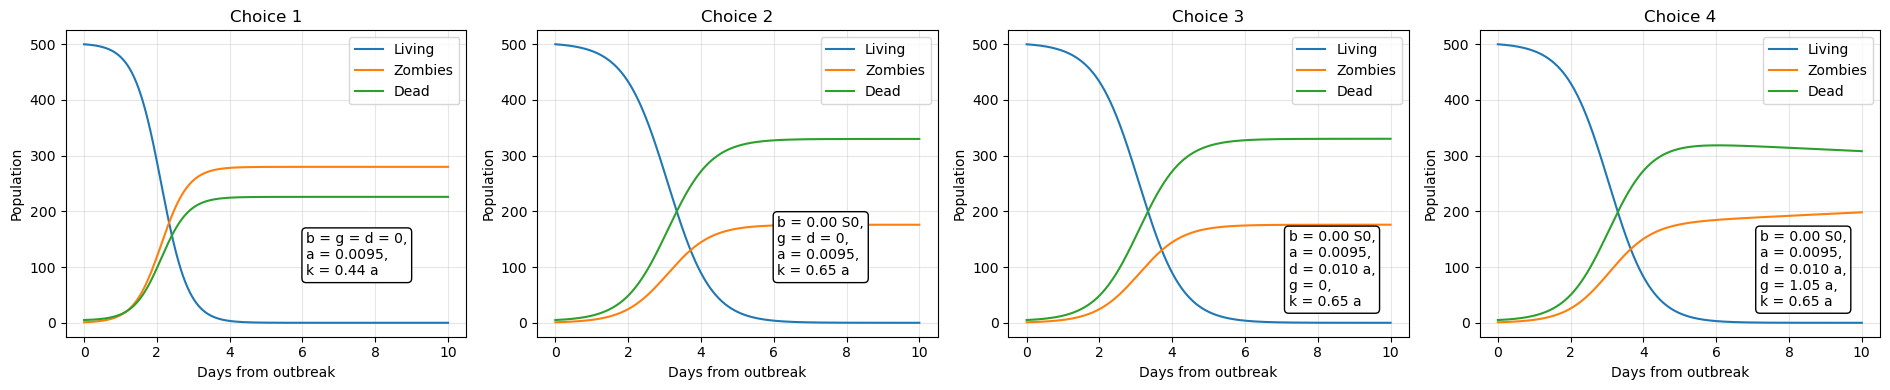

In [39]:

# Scenario 1: 1% initial dead population. 0.2% initial zombies
# ---------------------------
S0 = 500   # initial population
Z0 = 1     # initial zombie population
R0 = 5     # initial dead population

y0 = (S0, Z0, R0)

t = np.linspace(0, 10.0, 1000)  # time grid for the simulation

# Create the figure and subplots for plotting the results
fig, axs = plt.subplots(1, 4, figsize=(19, 4))

# Run simulations for four different parameter choices

#====================================================================================================
# Choice No. 1: Update the parameter values below according to these rules
# There are no newborns. No humans dying of natural causes and no zombie rising from the dead. 
# but let's give a fighting chance to the human. 
# Choose the kill parameter to be 65% the transmission parameter.

b = 0.0      # Birth rate, i.e. number of births per day
d = 0.0000  # Natural death rate (per day). Its product by S represents the number of humans dying from natural causes per day
a = 0.0095   # Transmission/attack rate (per day). Its product by SZ represents the number of human-zombie encounters resulting in a new zombie  per day
g = 0.0000  # Resurrect rate (per day). Its product by R represents the number of dead humans resurrecting as zombies  per day
k =  0.0042 # Kill/destroy rate (per day). Its product by SZ represents the number of encounters where humans successfully destroy zombies  per day

params = (b, d, a, g, k)
annotation = f"b = g = d = 0,\na = {a:.4f},\nk = {k/a:.2f} a"
xy_coord = (0.6, 0.2)
t, S, Z, R = run_simulation(y0, params, axs[0], title = "Choice 1", 
                            annotation = annotation,
                           xy_coord=xy_coord)  

#====================================================================================================
# Choice No. 2: Update the parameter values below according to these rules
# No humans dying of natural causes and no zombie rising from the dead. 
# Let's give a fighting chance to the human. Choose the kill parameter to be 65% the transmission parameter.
# Let's add back the newborns. Choose b to be 1% of the initial population.

b = 0.01     # Birth rate, i.e. number of births per day
d = 0  # Natural death rate (per day). Its product by S represents the number of humans dying from natural causes per day
a = 0.0095   # Transmission/attack rate (per day). Its product by SZ represents the number of human-zombie encounters resulting in a new zombie  per day
g = 0  # Resurrect rate (per day). Its product by R represents the number of dead humans resurrecting as zombies  per day
k = .006175   # Kill/destroy rate (per day). Its product by SZ represents the number of encounters where humans successfully destroy zombies  per day
# Collect all params into a tuple for good organization
params = (b, d, a, g, k)
annotation = f"b = {b/S0:.2f} S0,\ng = d = 0,\na = {a:.4f},\nk = {k/a:.2f} a"
xy_coord = (0.6, 0.2)
t, S, Z, R = run_simulation(y0, params, axs[1], title = "Choice 2", 
                            annotation = annotation,
                           xy_coord=xy_coord) 

#====================================================================================================
# Choice No. 3: Update the parameter values below according to these rules
# Still no resurrecting zombies
# Fighting chance to the human. Choose the kill parameter to be 65% the transmission parameter.
# Add back the newborns. Choose b to be 5% of the initial population.
# Add back the death rates. Choose the humans' natural death rate to be 1% of the transmission parameter.

b = .05 #173     # Birth rate, i.e. number of births per day
d = 0.000095 #0438  # Natural death rate (per day). Its product by S represents the number of humans dying from natural causes per day
a = 0.0095   # Transmission/attack rate (per day). Its product by SZ represents the number of human-zombie encounters resulting in a new zombie  per day
g = 0  # Resurrect rate (per day). Its product by R represents the number of dead humans resurrecting as zombies  per day
k = .006175   # Kill/destroy rate (per day). Its product by SZ represents the number of encounters where humans successfully destroy zombies  per day

# Collect all params into a tuple for good organization
params = (b, d, a, g, k)
annotation = f"b = {b/S0:.2f} S0,\na = {a:.4f},\nd = {d/a:.3f} a,\ng = 0,\nk = {k/a:.2f} a"
xy_coord = (0.7, 0.1)
t, S, Z, R = run_simulation(y0, params, axs[2], title = "Choice 3", annotation = annotation, xy_coord=xy_coord) 

#====================================================================================================
# Choice No. 4: Update the parameter values below according to these rules
# Fighting chance to the human. Choose the kill parameter to be 65% the transmission parameter.
# Add back the newborns. Choose b to be 5% of the initial population.
# Add back the death rates. Choose the humans' natural death rate to be 1% of the transmission parameter.
# Resurrecting zombies. Choose the resurrection parameter to be 1% of the initial zombie population

b = .05  # Birth rate, i.e. number of births per day
d =  .000095# Natural death rate (per day). Its product by S represents the number of humans dying from natural causes per day
a = 0.0095   # Transmission/attack rate (per day). Its product by SZ represents the number of human-zombie encounters resulting in a new zombie  per day
g =  .01 # Resurrect rate (per day). Its product by R represents the number of dead humans resurrecting as zombies  per day
k = .006175  # Kill/destroy rate (per day). Its product by SZ represents the number of encounters where humans successfully destroy zombies  per day

# Collect all params into a tuple for good organization
params = (b, d, a, g, k)
annotation = f"b = {b/S0:.2f} S0,\na = {a:.4f},\nd = {d/a:.3f} a,\ng = {g/a:.2f} a,\nk = {k/a:.2f} a"
xy_coord = (0.7, 0.1)
t, S, Z, R = run_simulation(y0, params, axs[3], title = "Choice 4",
                            annotation = annotation,
                           xy_coord = xy_coord) 


plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()  # Display the plots


Did you see what we did there? Let's recap. There were too many parameters in the model, so we started by setting all parameters to 0 except for two: `a` and `k`. The plot in choice 1 shows us that if there were only humans and zombies, the zombies would overtake the human population in about 3 days. However, after three days there are not that many humans left and the zombie population quickly reaches a fixed value. If you were to change the `k` parameter to be less than 50% of `a` you will find the orange line be higher than the green line (go try it!). If we are to look at the equations we would find the whole story. Choice 1 leads to these equations

$$\frac{dS}{dt} = - aSZ,$$
$$\frac{dZ}{dt} = (a - k)SZ,$$
$$\frac{dR}{dt} = kSZ.$$

As long as `a > k` the zombies and the dead will increase in number, while the humans will always decrease in number. If the ratio $(a-k)/k$ is bigger than 1 then the green line will always be higher than the orange line. If instead $(a - k)/k > 1$ then the orange line will be higher than the green line. Obviously the initial values will play a role here too, but I am considering those fixed at the moment. 

Next we introduce a human resource; newborns. This increases the human population by a little in the early days but does not change the fact that zombies still overtake the humans in three days. Notice the difference between choice 1 and choice 2 though. The dead and zombie populations keep rising almost with the same slope. The value `b >0` allows for `S` to never vanish and provide humans to be turned into zombies and consequently into dead. If you were to change the value of `b` you will notice that it determines the slope of the orange and green lines after day 3. 

Next we introduce a death rate for the humans. The major effect of this is to increase the speed at which the number of dead people increases leading to a wider gap between the green and orange line at day 10. Finally, we tried to close that gap by increasing the number of zombies created per day by making the resurrection parameter nonzero. 

In conclusion, when you are presented with a complicated model that is difficult to understand, try reducing it to a much simpler model by setting most parameters to zero except for a few. This allows you to set a baseline. Then add new parameters one by one to learn their effect on the model.

Ok. Now that we have learned more about the model's parameters let's try different initial scenarios and let's see if we can survive a zombie apocalypse.

### Initial conditions

The next important thing about our model is the initial state of the system. This is important because different initial conditions can lead to different final states. What we want to explore next is how big of an impact the initial populations ($S,Z,R$) have. For example, given a set of model parameters, what happens if the there are no initial zombies? What is the minimum population of zombies needed for the apocalypse? How many dead people are enough to have a zombie apocalypse?  

In the next code cell we will run three scenarios. 

**Run the code below which produces three plots. Make sure to read the differences between the three scenarios and understand how the code works. You will be using it later.**

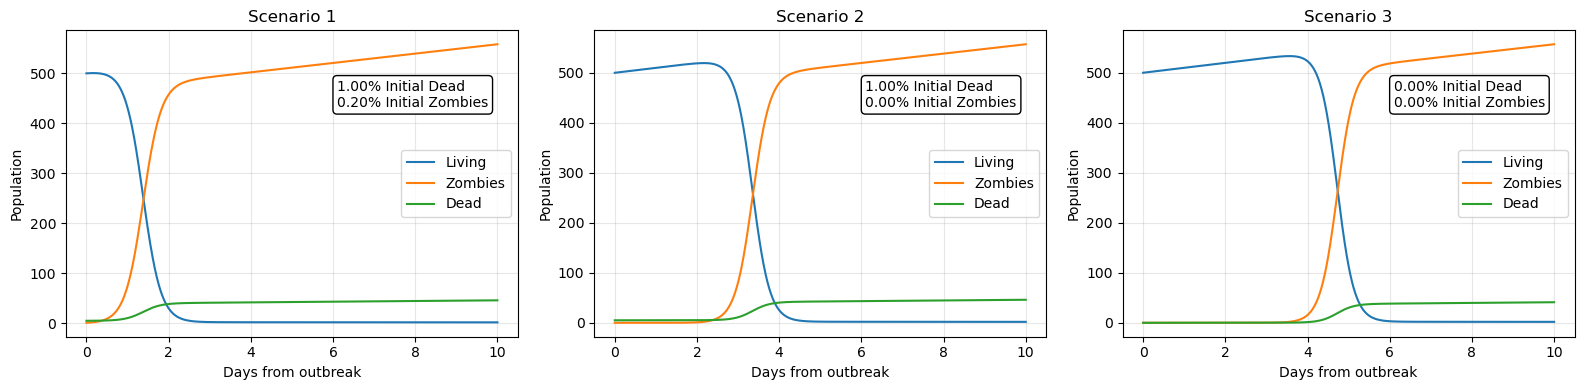

In [4]:
# Model parameters definition
# ---------------------------
# These parameters define the behavior of the model according to the SZR dynamics.
b = 10.     # Birth rate, i.e. number of births per day
d = 0.0001  # Natural death rate (per day). Its product by S represents the number of humans dying from natural causes per day
a = 0.0095  # Transmission/attack rate (per day). Its product by SZ represents the number of human-zombie encounters resulting in a new zombie  per day
g = 0.0001  # Resurrect rate (per day). Its product by R represents the number of dead humans resurrecting as zombies  per day
k = 0.00065  # Kill/destroy rate (per day). Its product by SZ represents the number of encounters where humans successfully destroy zombies  per day

# Collect all params into a tuple for good organization
params = (b, d, a, g, k)

t = np.linspace(0, 10., 1000)  # time grid for the simulation

# Create the figure and subplots for plotting the results
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# Run simulations under three different scenarios

# Scenario 1: 1% initial dead, 0.2% initial zombies
S0 = 500   # initial population
Z0 = 1     # initial zombie population
R0 = 5     # initial dead population

y0 = (S0, Z0, R0)
# Constructing text to be put in the plots based on the simulation parameters
annotation = f'{R0/S0*100:.2f}% Initial Dead\n{Z0/S0*100:.2f}% Initial Zombies'

t, S, Z, R = run_simulation(y0, params, axs[0], title = "Scenario 1", annotation = annotation)  

# Scenario 2: 1% initial dead population. No initial zombies
S0 = 500   # initial population
Z0 = 0     # initial zombie population
R0 = 5     # initial dead population

y0 = (S0, Z0, R0)
# Constructing text to be put in the plots based on the simulation parameters
annotation = f'{R0/S0*100:.2f}% Initial Dead\n{Z0/S0*100:.2f}% Initial Zombies'
t, S, Z, R = run_simulation(y0, params, axs[1], title = "Scenario 2", annotation = annotation) 

# Scenario 3: No initial dead population. No initial zombies
S0 = 500   # initial population
Z0 = 0     # initial zombie population
R0 = 0     # initial dead population

y0 = (S0, Z0, R0)
# Constructing text to be put in the plots based on the simulation parameters
annotation = f'{R0/S0*100:.2f}% Initial Dead\n{Z0/S0*100:.2f}% Initial Zombies'
t, S, Z, R = run_simulation(y0, params, axs[2], title = "Scenario 3", annotation = annotation) 

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()  # Display the plots
fig.savefig('Scenarios.png')

&#9989; **Questions:** Answer these questions

1. What are the qualitative differences between the plots? Is there a scenario in which humanity is not doomed?
2. What is the human population on day 10 in each scenario? You might want to use code for this.
3. Looking at the model (the figure with the blue boxes), what do you think is the reason for the zombie apocalypse even in scenario 3?
4. Why do the number of zombies keeps increasing even when humans population is almost zero?
5. Take a look at the value of the model parameters. What do you notice?

<font size=8 color="#009600">&#9998;</font> 1. Yea humanity is pretty doomed.  The smaller the dead and zombie populations are, the longer the humans last.

---
### SIZR Model

Well, no matter the initial conditions the human population is destined to extiction. Better start watching zombie movies and TV shows to prepare for the inevitable! 

Obviously that model does not completely represent reality, so let's make this a little more realistic. Assume that once you are bitten by a zombie you have sometime before turning into one, but you can still die by natural causes (not killed by your friends who found the bite mark). We need to modify the code above to have a "latent/infected" class, which we will call **I**, and call this the SIZR model. Changes to the basic model include:

- Susceptibles first move to an infected class once infected and remain there for some period of time.
- Infected individuals can still die a ‘natural’ death before becoming zombies; otherwise, they become zombies at a certain rate. __Note:__ In many disease models, this might be called **L** for latent so that **I** can be used to refer to those that are infectious (i.e. can spread the disease). In our zombie model, the fully infected group is represented by Z.  (Zombie invasions are not your standard infectious disease!)

When we model infectious diseases, you will see more of this notation.  The model can now be presented graphically as:

<img src="https://i.ibb.co/YtRmd9h/zombie-model-SIZR.png" alt="zombie-model-SIZR" border="0" width=860>

&#9989; **Task:** In the next code cell 

- **write a function that defines the SIZR equations**. You can copy the code for `derivatives_szr` and modify it accordingly. For this model **you need to implement a new parameter, $r$**. Instead, use $r = 0.5$. You can ask AI to write the function for you, however, make sure to ask AI to write descriptive comments and a docstrings! Don't forget to cite the prompt and the AI you used.  
- **copy the `run_simulation` function and modify it so that it calls the SIZR model and plots the I compartments in the plots**. Again you can ask AI too.
- **in a new code cell copy the code for the three scenarios and run the simulations for 20 days** since the latent phase will stall the zombie take-over!

You should get something that looks like this:

![latent.png](./latent.png)
<!-- <img src="https://i.imgur.com/i3FuLFC.png" width=500px>
 -->
Put your code and plots here:

In [5]:
# Put the SIZR model function and the modified run_simulation function here
def derivatives_sizr(t, y, b, d, a, g, k, r):
    Si, Ii, Zi, Ri = y  # Unpack the current values of the populations
    # Model equations (based on Munz et al. 2009)
    dSdt = b * Si - a * Si * Zi - d * Si  # Change in susceptible population
    dIdt = a * Si * Zi - Ii * r - d * Ii # Change in infected population
    dZdt = r * Ii + g * Ri - k * Si * Zi # Change in zombie population
    dRdt = d * Si+ Ii * d + k * Si * Zi - g * Ri  # Change in removed (dead) population
    return [dSdt, dIdt, dZdt, dRdt]

def run_simulation(initial_state, model_parameters, ax, title, annotation, xy_coord = (0.6, 0.75)):
    # Solve the differential equations for the zombie apocalypse model
    soln = solve_ivp(derivatives_sizr, (t[0], t[-1]), initial_state, t_eval=t, args= model_parameters)
    S, I, Z, R = soln.y  # Extract the solution for S (susceptible), I, Z (zombies), and R (removed)

    # Plot the simulation results
    ax.plot(t, S, label='Living')  # Plot the living human population
    ax.plot(t, I, label = 'Infected')
    ax.plot(t, Z, label='Zombies')  # Plot the zombie population
    ax.plot(t, R, label='Dead')
    ax.set_xlabel('Days from outbreak')  # Label the x-axis
    ax.set_ylabel('Population')  # Label the y-axis
    
    # Annotating the plot with simulation parameters for clarity
    ax.annotate(annotation, # Text to be put in the plot
                xy_coord, # Location in the plot where to put the annotation. Note these numbers should be between 0 and 1 because we choose axes_fraction next
                xycoords='axes fraction',  #
                ha='left', # ha = horizontal alignment. 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
               )
    ax.set_title(title)
    # ax.set_yscale('log')
    ax.grid(alpha = 0.3)
    ax.legend(loc='best')  # Display the legend

    solution = [t, S, I, Z, R]
    
    return solution

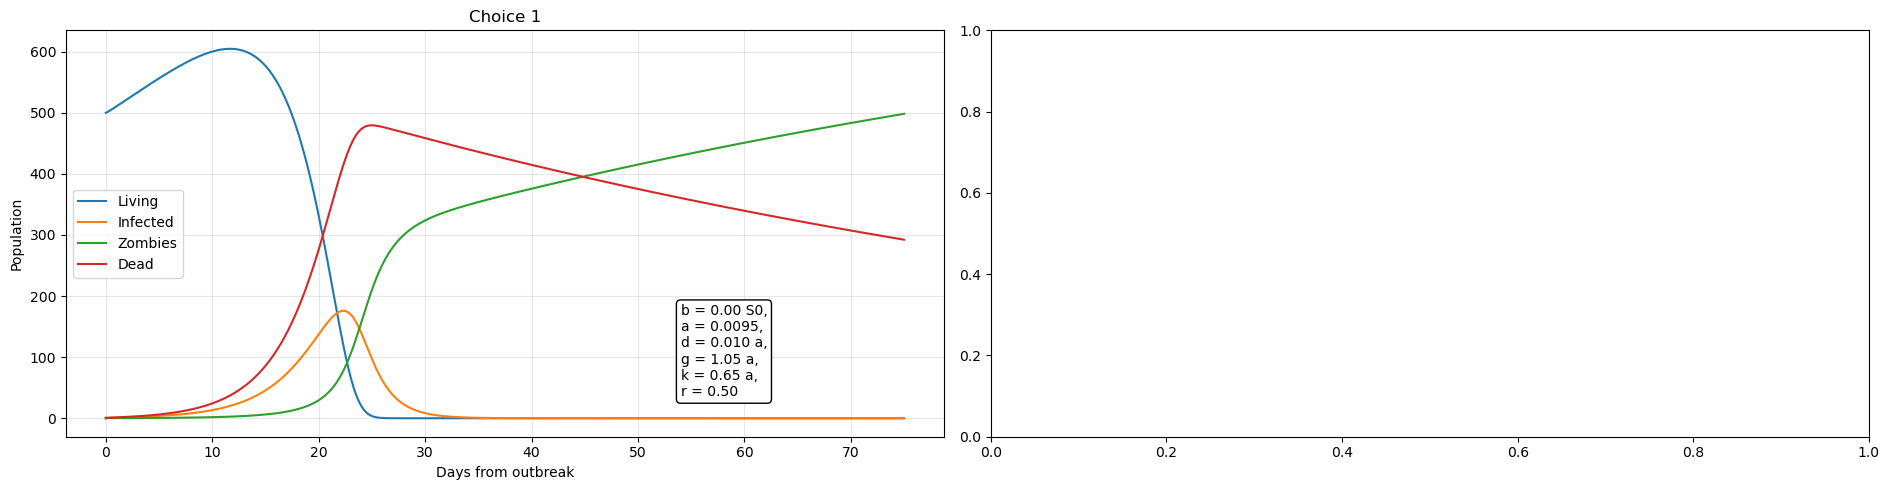

In [6]:
# Copy the scenario code in here. Increase the maximum time to 20. 
S0 = 500   # initial population
I0 = 0
Z0 = 1     # initial zombie population
R0 = 0     # initial dead population

y0 = (S0, I0, Z0, R0)

t = np.linspace(0, 75.0, 1000)  # time grid for the simulation

# Create the figure and subplots for plotting the results
fig, axs = plt.subplots(1, 2, figsize=(19, 5))

# Run simulations for four different parameter choices

#====================================================================================================
b = .025  # Birth rate, i.e. number of births per day
d =  .01*a # Natural death rate (per day). Its product by S represents the number of humans dying from natural causes per day
a = 0.0095   # Transmission/attack rate (per day). Its product by SZ represents the number of human-zombie encounters resulting in a new zombie  per day
g =  .01 # Resurrect rate (per day). Its product by R represents the number of dead humans resurrecting as zombies  per day
k = .65*a  # Kill/destroy rate (per day). Its product by SZ represents the number of encounters where humans successfully destroy zombies  per day
r = .5  #Rate infected turn into zombies (per day)

# Collect all params into a tuple for good organization
params = (b, d, a, g, k, r)
annotation = f"b = {b/S0:.2f} S0,\na = {a:.4f},\nd = {d/a:.3f} a,\ng = {g/a:.2f} a,\nk = {k/a:.2f} a,\nr = {r:.2f}"
xy_coord = (0.7, 0.1)
t, S, I, Z, R = run_simulation(y0, params, axs[0], title = "Choice 1",
                            annotation = annotation,
                           xy_coord = xy_coord) 

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()  # Display the plots

As you can see the addition of the **I** (sick) people has slowed down the takeover of zombies. The new thing to note here is the sick (orange) curve. Before the takeover date the orange curve is always higher that the green line as it should. You get sick first and then you turn into a zombie. The orange curve reaches a peak right after the takeover date and then quickly decreases to zero. Again, this makes sense. When there are more zombies than humans, more humans will get sicker and but as soon as the number of humans becomes low there are not enough humans to get sick and the green curve decreases. Whenever you change your model you want to check that the new model makes sense. 

---
### SIZR model with a cure, SIZRC 

Let's get one step further. If/when there is a zombie invasion, the Centers for Disease Control and Prevention will be in charge of mitigating the impending disaster (we hope!). There are various tools in their toolbox for doing this, which have been developed for other diseases, but they are very busy dealing with things like the Coronavirus to have the resources to think about zombies right now. It would be great if you could help them by thinking about what to do in advance. Luckily, some work has already been done on this. Munz et al. have explored two mitigation strategies:
* quarantine
* treatment

For now, we would like to incorportate treatment aspects into this model.  In short, we want to be able to cure the zombies at a rate, $c$.  This new SIZRC model with a cure can be presented as:

<img src="https://i.ibb.co/Z139DCk/zombie-model-SIZR-w-CURE.png" alt="zombie-model-SIZR-w-CURE" border="0" width=860>

&#9989; **Task:** In the next code cell

- similarly to what you have done above, **write a new function for calculating the derivatives of the new SIZRC model**. Make sure to include the the curative effect presented in the graphic above.
- **write some code that make a plot comparing all three models.** A new function that makes a plot that presents the results from all three models using the original initial conditions:
1. the SZR model
2. the SIZR model
3. SIZR with cure (two cases)
Let's try two different cases for the cure rate, $c$, representing the rate in 1/days at which we can treat people. Let's compare a fantastic treatment with a $c=1/2$ (takes two days to cure someone) and a mediocre treatment $c=1/7$.

Here is an example

![image.png](ModelComparison.png)

In [26]:
# Put the SIZR model function and the modified run_simulation function here
def derivatives_sizrc(t, y, b, d, a, g, k, r, c):
    Si, Ii, Zi, Ri = y  # Unpack the current values of the populations
    # Model equations (based on Munz et al. 2009)
    dSdt = b * Si - a * Si * Zi - d * Si + c * Zi # Change in susceptible population
    dIdt = a * Si * Zi - Ii * r - d * Ii          # Change in infected population
    dZdt = r * Ii + g * Ri - k * Si * Zi - c * Zi # Change in zombie population
    dRdt = d * Si+ Ii * d + k * Si * Zi - g * Ri  # Change in removed (dead) population
    return [dSdt, dIdt, dZdt, dRdt]

def run_simulation(initial_state, model_parameters, ax, title, annotation, xy_coord = (0.6, 0.75)):
    # Solve the differential equations for the zombie apocalypse model
    soln = solve_ivp(derivatives_sizrc, (t[0], t[-1]), initial_state, t_eval=t, args= model_parameters)
    S, I, Z, R = soln.y  # Extract the solution for S (susceptible), I, Z (zombies), and R (removed)

    # Plot the simulation results
    ax.plot(t, S, label='Living')  # Plot the living human population
    ax.plot(t, I, label = 'Infected')
    ax.plot(t, Z, label='Zombies')  # Plot the zombie population
    ax.plot(t, R, label='Dead')
    ax.set_xlabel('Days from outbreak')  # Label the x-axis
    ax.set_ylabel('Population')  # Label the y-axis
    
    # Annotating the plot with simulation parameters for clarity
    ax.annotate(annotation, # Text to be put in the plot
                xy_coord, # Location in the plot where to put the annotation. Note these numbers should be between 0 and 1 because we choose axes_fraction next
                xycoords='axes fraction',  #
                ha='left', # ha = horizontal alignment. 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
               )
    ax.set_title(title)
    # ax.set_yscale('log')
    ax.grid(alpha = 0.3)
    ax.legend(loc='best')  # Display the legend

    solution = [t, S, I, Z, R]
    
    return solution

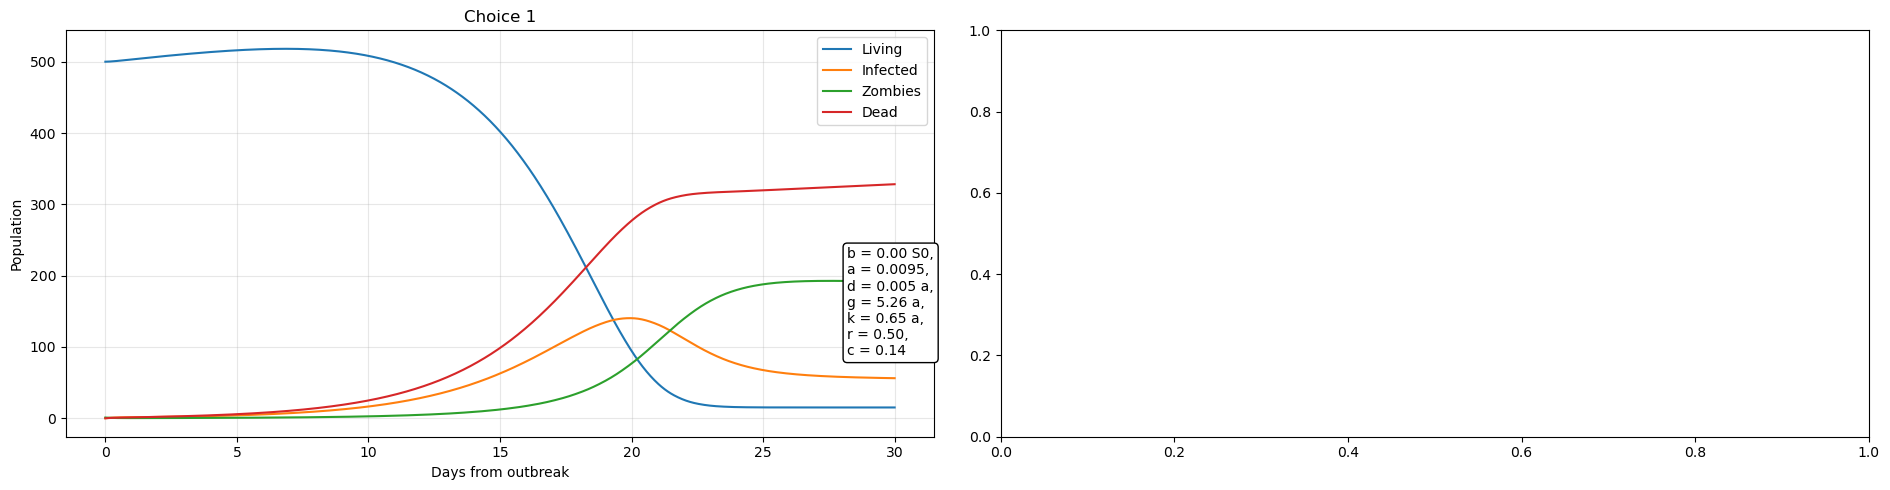

In [34]:
# Copy the scenario code in here. Increase the maximum time to 20. 
S0 = 500   # initial population
I0 = 0
Z0 = 1     # initial zombie population
R0 = 0     # initial dead population

y0 = (S0, I0, Z0, R0)

t = np.linspace(0, 30.0, 1000)  # time grid for the simulation

# Create the figure and subplots for plotting the results
fig, axs = plt.subplots(1, 2, figsize=(19, 5))

# Run simulations for four different parameter choices

#====================================================================================================
b = .01  # Birth rate, i.e. number of births per day
d =  .01*a # Natural death rate (per day). Its product by S represents the number of humans dying from natural causes per day
a = 0.0095   # Transmission/attack rate (per day). Its product by SZ represents the number of human-zombie encounters resulting in a new zombie  per day
g =  .05 # Resurrect rate (per day). Its product by R represents the number of dead humans resurrecting as zombies  per day
k = .65*a  # Kill/destroy rate (per day). Its product by SZ represents the number of encounters where humans successfully destroy zombies  per day
r = .5  #Rate infected turn into zombies (per day)
c = 1/7 #Cure Rate

# Collect all params into a tuple for good organization
params = (b, d, a, g, k, r, c)
annotation = f"b = {b/S0:.2f} S0,\na = {a:.4f},\nd = {d/a:.3f} a,\ng = {g/a:.2f} a,\nk = {k/a:.2f} a,\nr = {r:.2f}, \nc = {c:.2f}"
xy_coord = (0.9, 0.2)
t, S, I, Z, R = run_simulation(y0, params, axs[0], title = "Choice 1", annotation = annotation, xy_coord = xy_coord) 

plt.tight_layout()  # Adjust subplot parameters to give specified padding 
plt.show()  # Display the plots 

**What do you conclude?** Based on your results, what is your recommendation to the CDC about your treatments?  Are they good enough for people to survive?  What aspects of the model do you feel need to be refined?

<font size="+3">&#9998;</font>*1/7 was nowhere near enough to be effective.  If the cure was able to be used on infected persons and not just zombies it would be incredibly effective, and if the potency and delivery (c) could be increased it would also be more effective*

## Optional
If you want additional practice or have aspirations to work in zombie mitigation in your career, consider implementing the quarantine mitigation strategy discussed in the Munz paper.  Is a quarantine system a worthy strategy to save the human race?

Since cure is so limited, isolating people who are infected would drastically decrease a the attack value and preserve the number of humans

---
## Assignment Wrap-up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credit for the assignment!**

In [23]:
from IPython.display import HTML

HTML("""
<iframe 
	src="https://cmse.msu.edu/cmse201-pc-survey" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
""")

### Congratulations, you're done!

Submit this assignment by uploading it to the course D2L web page.  Go to the "Pre-class assignments" folder, find the appropriate submission link, and upload it there.

See you in class!

&#169; Copyright 2023,  Department of Computational Mathematics, Science and Engineering at Michigan State University